In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics

print(tf.__version__)

2.3.0


170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000,)


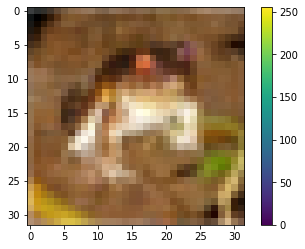

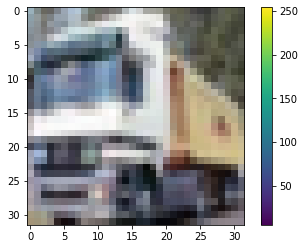

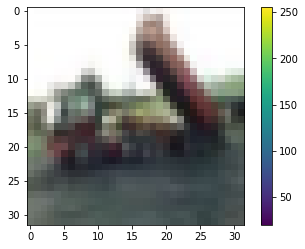

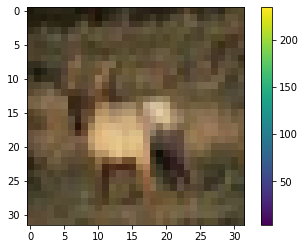

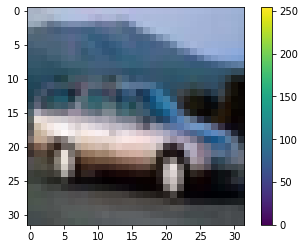

In [2]:
(x, y),(x_test, y_test) = datasets.cifar10.load_data()
y = tf.squeeze(y,axis=1)
y_test = tf.squeeze(y_test,axis=1)
print(x.shape,y.shape)

for i in range(5):
  plt.figure()
  plt.imshow(x[i])
  plt.colorbar()
  plt.grid(False)

In [3]:
print(x.shape, y.shape)

(50000, 32, 32, 3) (50000,)


In [4]:
def feature_scale(x,y):
  x = tf.cast(x,dtype=tf.float32)/255.
  y = tf.cast(y,dtype=tf.int32)
  return x,y

In [5]:
# 利用keras建構VGG16的隱藏層
vgg_layers_16 = [
    #stack1
    layers.Conv2D(64,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(64,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),
    #stack2
    layers.Conv2D(128,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(128,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),
    #stack3
    layers.Conv2D(256,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(256,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(256,kernel_size=[1,1],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),
    #stack4
    layers.Conv2D(512,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(512,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(512,kernel_size=[1,1],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),    
    #stack5
    layers.Conv2D(512,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(512,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(512,kernel_size=[1,1],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same')
]
# 此處全連接層與論文所建置的有所不同，因考量參數量
fc_layers =[
    layers.Dense(256,activation=tf.nn.relu),
    layers.Dense(256,activation=tf.nn.relu),
    layers.Dense(10,activation=None),
]

In [6]:
vgg_16 = Sequential(vgg_layers_16)
vgg_16.build(input_shape=[None,32,32,3])
fc = Sequential(fc_layers)
fc.build(input_shape=[None,512])

optimizer = optimizers.Adam(lr=0.0001)

In [7]:
data = tf.data.Dataset.from_tensor_slices((x,y))
data = data.map(feature_scale).shuffle(10000).batch(256)

data_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
data_test = data_test.map(feature_scale).batch(256) 

In [8]:
data_iter = iter(data)
samples = next(data_iter)
print(samples[0].shape,samples[1].shape)

(256, 32, 32, 3) (256,)


In [9]:
vgg_16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

In [10]:
variables = vgg_16.trainable_variables + fc.trainable_variables
for i in range(10):
  for step,(x,y) in enumerate(data):
    with tf.GradientTape() as tape:
      logits = vgg_16(x)
      logits = tf.reshape(logits,[-1,512])
      logits = fc(logits)
      y_one_hot = tf.one_hot(y,depth=10)
      loss = tf.losses.categorical_crossentropy(y_one_hot,logits,from_logits=True)
      loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(grads,variables))
    
    if step %100==0:
      print('Epoch: ',i,'\tStep: ',step,'\tloss: ',float(loss))
  total_loss = 0
  total_num=0
  for x,y in data_test:

    logits = vgg_16(x)
    logits = tf.reshape(logits,[-1,512])

    logits = fc(logits)
    prob = tf.nn.softmax(logits,axis=1)
    pred = tf.argmax(prob,axis=1)

    pred = tf.cast(pred,dtype=tf.int32)
    correct = tf.equal(pred,y)

    result = tf.reduce_sum(tf.cast(correct,dtype=tf.int32))

    total_loss += int(result)
    total_num += x.shape[0]

  acc = total_loss/total_num
  print(i,'acc:',acc)

Epoch:  0 	Step:  0 	loss:  2.302468776702881
Epoch:  0 	Step:  100 	loss:  1.9124233722686768
0 acc: 0.3617
Epoch:  1 	Step:  0 	loss:  1.739848017692566
Epoch:  1 	Step:  100 	loss:  1.7367790937423706
1 acc: 0.4084
Epoch:  2 	Step:  0 	loss:  1.7003859281539917
Epoch:  2 	Step:  100 	loss:  1.4425578117370605
2 acc: 0.4561
Epoch:  3 	Step:  0 	loss:  1.47150719165802
Epoch:  3 	Step:  100 	loss:  1.2546601295471191
3 acc: 0.5637
Epoch:  4 	Step:  0 	loss:  1.2006893157958984
Epoch:  4 	Step:  100 	loss:  1.0756688117980957
4 acc: 0.5937
Epoch:  5 	Step:  0 	loss:  1.0667221546173096
Epoch:  5 	Step:  100 	loss:  0.9635378122329712
5 acc: 0.619
Epoch:  6 	Step:  0 	loss:  0.9362624287605286
Epoch:  6 	Step:  100 	loss:  1.0559881925582886
6 acc: 0.6374
Epoch:  7 	Step:  0 	loss:  0.9489791393280029
Epoch:  7 	Step:  100 	loss:  0.8208396434783936
7 acc: 0.6307
Epoch:  8 	Step:  0 	loss:  0.9212504029273987
Epoch:  8 	Step:  100 	loss:  0.7861034870147705
8 acc: 0.6761
Epoch:  9 	Step